In [1]:
import sparse
import subprocess
import shlex
import pandas as pd
import numpy as np

import glob
import os
import wget
import requests
import glob
import time
import dask
import h5py

from Bio import SeqIO
import pickle
import sys
sys.setrecursionlimit( 10 **9 )
from sklearn.cluster import *
from sklearn.metrics import roc_curve , precision_recall_curve , auc

import scipy
import copy
from numpy import linalg as LA
from matplotlib import pyplot as plt
import random
import h5py
import itertools
import dendropy
import os
import psutil
import seaborn as sns


overwrite = False
jk_iterations = 5
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'AVX2'

In [2]:
import torch
#create graphs on the fly to represent pairs of profiles
device = torch.device('cuda' )
#device = torch.device('cpu')
print(device)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import ChebConv
from torch_geometric.nn import  to_hetero
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData ,InMemoryDataset
import copy
import time
import pickle
import random

In [4]:
filedir = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/'

In [5]:

files = glob.glob( '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl')
print(files)

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl']


In [6]:
#treefile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.aln.EPIID.treefile'
#alnfile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.aln'
alnfile = filedir + 'datasets/covid_data/msa_0730/msa_0730.fasta'

treefile = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/feb_2021/GISAID-hCoV-19-phylogeny-2021-02-21/global.tree'
modeldir = filedir+'datasets/covid_data/structs/'

alnh5 = alnfile+'.h5'
#ts = '2021-08-08T11:16:34.358764'
#ts = '2021-08-08T14:37:59.736512'
#events = alnfile+'*'+ts+'*'
eventmats = files

In [7]:
with open(treefile) as treelines:
    print( next(treelines)[0:1000])

(EPI_ISL_406801:0,(EPI_ISL_413691:0.0,EPI_ISL_414663:0.0,EPI_ISL_414691:0.0,EPI_ISL_414690:0.0,EPI_ISL_414689:0.0,EPI_ISL_413729:0.0,EPI_ISL_413750:0.0,EPI_ISL_413746:0.0,EPI_ISL_413748:0.0,EPI_ISL_428470:0.0,EPI_ISL_428471:0.0,EPI_ISL_428476:0.0,EPI_ISL_429854:0.0,EPI_ISL_429091:0.0,EPI_ISL_429090:0.0,EPI_ISL_429093:0.0,EPI_ISL_429092:0.0,EPI_ISL_429075:0.0,EPI_ISL_429082:0.0,EPI_ISL_429084:0.0,EPI_ISL_429083:0.0,EPI_ISL_407893:0.0,EPI_ISL_416326:0.0,EPI_ISL_416352:0.0,EPI_ISL_407976:0.0,EPI_ISL_411926:0.0,EPI_ISL_421246:0.0,EPI_ISL_421244:0.0,EPI_ISL_421242:0.0,EPI_ISL_421240:0.0,EPI_ISL_421237:0.0,EPI_ISL_421249:0.0,EPI_ISL_421247:0.0,EPI_ISL_412979:0.0,EPI_ISL_408480:0.0,EPI_ISL_449481:0.0,EPI_ISL_449484:0.0,EPI_ISL_451384:0.0,EPI_ISL_457687:0.0,EPI_ISL_457688:0.0,EPI_ISL_457689:0.0,EPI_ISL_457690:0.0,EPI_ISL_457692:0.0,EPI_ISL_457693:0.0,EPI_ISL_457695:0.0,EPI_ISL_457696:0.0,(EPI_ISL_463895:5e-09,((EPI_ISL_537438:0.000134997,(((EPI_ISL_412982:0.00010032,(((EPI_ISL_428674:3.3427e-0

In [8]:
tree = dendropy.Tree.get( path=treefile, schema='newick' )

In [9]:
#setup the internal nodes for the fitch algo
for i,l in enumerate(tree.nodes()):
    l.event = {}
    l.scores = {}
    l.symbols = None
    l.char= None
    l.matrow = i
    

In [10]:
import networkx as nx
import colour
#quick and dirty check of trees

def tree_circle(node, start , sliver  ):
    if start == True :
        global count
        count = 0
    for i,child in enumerate(node.child_nodes()):
        if child.is_leaf() == True:
            child.radians = count*sliver
            count+=1
        if child.radians is None and child.is_leaf() == False :
            tree_circle( child , start = False , sliver = sliver  )
    radians = np.mean([ child.radians if child.radians else 0 for child in node.child_nodes() ])
    if node.radians is None:
        node.radians = radians

def phylograph(treein,labels , title = None):
    N = len(treein.nodes())
    tree = copy.deepcopy(treein)
    pdm = tree.phylogenetic_distance_matrix()
    sliver = 2*np.pi / len(tree.leaf_nodes())
    
    root = tree.seed_node
    radii = [ n.distance_from_root() for n in tree.nodes()]
    for n in tree.nodes():
        n.radians = None
    tree_circle(tree.seed_node, start=True , sliver = sliver)
    thetas = [n.radians for n in tree.nodes() ]
    pos = { i: [ np.sin(thetas[i])*radii[i] , np.cos(thetas[i])*radii[i]] for i in range(len(thetas)) }
    index = np.vstack([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    connectmat = np.zeros(( N ,  N ) )
    connectmat[index[:,0],index[:,1]] = 1 
    connectmat += connectmat.T
    G = nx.from_numpy_array(connectmat)
    red = colour.Color("red")
    blue = colour.Color("blue")
    crange = dict( zip ( list(set(labels)),  [ c.hex_l for c in list(red.range_to(blue, len(set(labels)) ) ) ] ) )
    colors = [crange[n] for n in labels ]
    #color according to downstream node
    edge_colors= [crange[labels[v]] for u,v in G.edges() ]
    #node size inversly proportional to number in graph
    plt.figure(figsize= (20,20) )
    if title:
        plt.title(title)
    nx.draw_networkx(G, pos = pos,  node_color = colors , node_size = 5, width = .5 , edge_color = edge_colors , with_labels=False)
    plt.show()

In [11]:
def ROC_curve(y_data, label = None):
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    for l in y_data:
        print(l)
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        fpr, tpr, _ = roc_curve(   y_pred_grd ,y_test)
        plt.plot(fpr, tpr, label=l + 'auc'+ str(auc(fpr, tpr) ))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_ROC.svg' )
    plt.show()
    
    
    plt.figure(figsize=(10,10))
    for l in y_data:
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        precision, recall, thresholds = precision_recall_curve( y_pred_grd, y_test)
        plt.plot( recall, precision , label= l )
        plt.ylabel('Precision')
        plt.xlabel('Recall')
    
    plt.title('PR curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_PR.svg' )
    plt.show()
    
def ROC_curve_single(y_test, y_pred_grd):
    fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, _ = roc_curve(y_test, y_pred_grd)
    plt.plot(fpr, tpr, label='single')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    precision, recall, thresholds = precision_recall_curve(  y_test , y_pred_grd)
    plt.plot(precision, recall , label='single')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

    plt.title('PR curve')
    plt.legend(loc='best')
    plt.show()


In [12]:
print( eventmats )

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl']


In [13]:

if os.path.exists( alnfile + '_IDs.pkl'):
    with open( alnfile + '_IDs.pkl' , 'rb') as idxin:
        IDindex = pickle.loads(idxin.read())
    IDs = dict(zip( IDindex.values() , IDindex.keys() ) )
else:
    
    msa = SeqIO.parse(alnfile , format = 'fasta')
    def clipID(ID):
        return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
    IDs = {i:rec.id for i,rec in enumerate(msa)}
    IDindex = dict(zip( IDs.values() , IDs.keys() ) )
    print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )
    with open( alnfile + '_IDs.pkl' , 'wb') as idxout:
        idxout.write(pickle.dumps(IDindex))

In [14]:
print(len(IDindex))

2212775


In [15]:
models = '7DZW, 6vxx,6zxn,5x58,6cs0,6sc1,6nb6, 2jw8, 2xab, 4aud1, 1yo4, 2acf, 2wct, 3vc8, 2gt7, 3ee7, 2g9t, 3ee7, 2g9t, 6jyt, 1ysy, 6nur, 2g9t, 5c8u, 2g9t, 2xyq, 4mm3, 6cs2, 6acg, 6acj, 6ack, 2dd8, 2ghw, 6nb6, 6nb7'
#models = '6vxx,6zxn'
models = models.split(',')

from Bio.PDB import *
dl_url = 'http://files.rcsb.org/download/'
dl_url_err = 'http://files.rcsb.org/download/'

structs = {}
already = glob.glob( modeldir+'/*.pdb' )
print(already)
#pull complexes
for m in models:
    structfile = modeldir+m.upper().strip()+'.pdb'
    if structfile not in already:
        print(m)
        time.sleep(1)
        try:
            wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
            structs[m] = structfile
        except:
            try:
                wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
                structs[m] = structfile
            except:
                print('err', m )
    else:
        structs[m.strip()] = structfile


['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2XAB.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NUR.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/5C8U.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YSY.pdb', '/work/FAC/FBM/DBC/cdess

In [16]:
modelfiles = modeldir + '*.pdb'
modelfiles = glob.glob( modelfiles )
print(modelfiles)

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2XAB.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NUR.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/5C8U.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YSY.pdb', '/work/FAC/FBM/DBC/cdess

In [17]:
from Bio.PDB import MMCIFParser, PDBParser , PDBIO
from Bio.PDB.mmcifio import MMCIFIO
parser = PDBParser()
import warnings
from Bio import SeqUtils

###compile all pdbs to fasta 
converter = SeqUtils.IUPACData.protein_letters_3to1
converter = { res.upper():converter[res] for res in converter}
chain_sequences={}
for model in modelfiles:
    print(model)
    with warnings.catch_warnings():
        try:
            m = model.split('/')[-1].replace('pdb' , '') 
            warnings.simplefilter("ignore")
            structure = parser.get_structure(m, model)
            io=PDBIO()
            io.set_structure(structure)
            chain_sequences[model]= { c.id : ''.join(  [ converter[ r.get_resname()] for r in c.get_residues() if 'CA' in r ] ) for c in structure.get_chains() }
            chain_sequences[model]={ c: chain_sequences[model][c] for c in chain_sequences[model] if len(chain_sequences[model][c])> 0 }
        except:
            print('err', model)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb
err /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb
err /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2XAB.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NUR.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmo

In [18]:
with open( modeldir + 'struct_chains.fasta', 'w') as fastout:
    for model in chain_sequences:
        for c in chain_sequences[model]:
            fastout.write( '> '+model+ ':'+c + '\n' + chain_sequences[model][c] + '\n' )

In [19]:

from dask.distributed import fire_and_forget
from dask.distributed import Client, Variable , Queue , Lock ,LocalCluster
from dask_jobqueue import SLURMCluster
from dask.distributed import  utils_perf
import dask
import dask.bag as db
import dask.array as da
import dask.dataframe as dd
from dask.delayed import delayed
from dask import delayed, compute

distributed_computation = False

print('flashing up a dask cluster')
if distributed_computation == True:
    
    NCORE = 4
    njobs = 20
    print('deploying cluster')
    cluster = SLURMCluster(
        walltime='1:00:00',
        n_workers = NCORE,
        cores=NCORE,
        processes = NCORE,
        interface='ib0',
        memory="10GB",
        env_extra=[
        'source /scratch/dmoi/miniconda/etc/profile.d/conda.sh',
        'conda activate ML'
        ],
        scheduler_options={'interface': 'ens3f0' }
    )
    print(cluster.job_script())
    cluster.adapt(minimum=10, maximum=100)
    time.sleep(5)

    print(cluster)
    print(cluster.dashboard_link)
    client = Client(cluster , timeout='450s' , set_as_default=True )
else:
    if __name__ == '__main__':
        NCORE = 10
        njobs = 1
        print('testing')
        cluster = LocalCluster(n_workers = NCORE )    
        print(cluster.dashboard_link)
        client = Client(cluster)
print('done')

/users/dmoi/.local/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


flashing up a dask cluster
testing
http://127.0.0.1:8787/status
done


In [20]:
nucleotide_mutation = None
AA_mutation = None
for mat in eventmats:
    with open( mat , 'rb') as pklin:
        mats = pickle.loads(pklin.read())
        print(mats)
        if AA_mutation is None:
            nucleotide_mutation = mats[1]
            AA_mutation = mats[0]
        else:
            nucleotide_mutation += mats[1]
            AA_mutation += mats[0]
print(nucleotide_mutation)
print(AA_mutation)

(<COO: shape=(741326, 29891, 380), dtype=float64, nnz=93228, fill_value=0.0>, <COO: shape=(741326, 29891, 12), dtype=float64, nnz=156073, fill_value=0.0>)
<COO: shape=(741326, 29891, 12), dtype=float64, nnz=156073, fill_value=0.0>
<COO: shape=(741326, 29891, 380), dtype=float64, nnz=93228, fill_value=0.0>


In [21]:
AAmat = AA_mutation.sum(axis = 2).to_scipy_sparse()

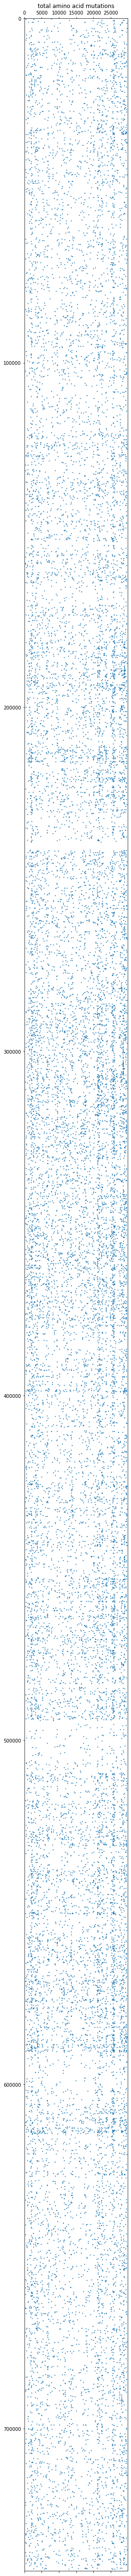

In [22]:
plt.figure(figsize=(10,100))
plt.spy(AAmat, markersize= .5)
plt.title('total amino acid mutations')
plt.show()

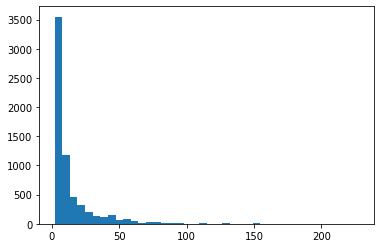

In [23]:
colsum = AAmat.sum(axis = 0)
colsum = colsum[colsum>1]
#colsum = colsum[colsum<100]

plt.hist(colsum.flat , bins = 40)
plt.show()

In [24]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


2119.4375


In [25]:
allowed_symbols = [ b'A', b'C', b'G' , b'T' ]
allowed_transitions = [ c1+c2 for c1 in allowed_symbols for c2 in allowed_symbols  if c1!= c2]
print('allowed transitions',allowed_transitions)

transition_dict = {  c : i  for i,c in enumerate( allowed_transitions )  }
rev_transition_dict= dict( zip(transition_dict.values(), transition_dict.keys()))
allowed_symbols = set(allowed_symbols)

print('transition dict', transition_dict)
ProteinAlphabet = [ 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y' ]
allowed_AA_transitions = [ c1+c2 for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2]
transitiondict_AA = {  c : i  for i,c in enumerate( allowed_AA_transitions )  }
rev_transitiondict_AA = dict( zip(transitiondict_AA.values(), transitiondict_AA.keys()))


allowed transitions [b'AC', b'AG', b'AT', b'CA', b'CG', b'CT', b'GA', b'GC', b'GT', b'TA', b'TC', b'TG']
transition dict {b'AC': 0, b'AG': 1, b'AT': 2, b'CA': 3, b'CG': 4, b'CT': 5, b'GA': 6, b'GC': 7, b'GT': 8, b'TA': 9, b'TC': 10, b'TG': 11}


741326
nodes


/users/dmoi/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


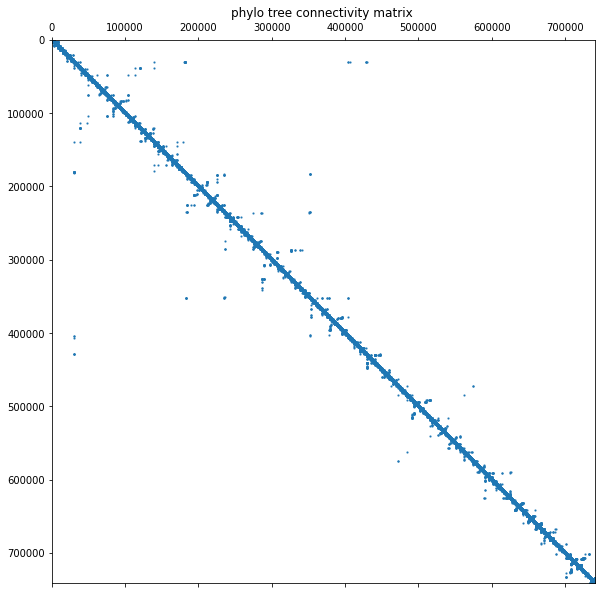

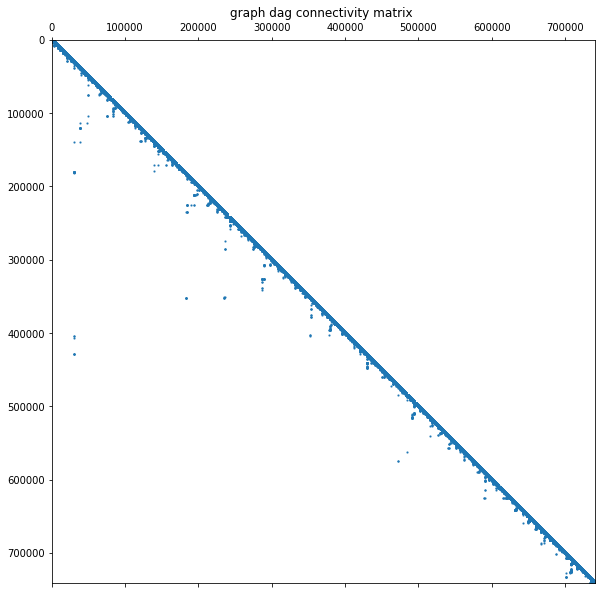

In [26]:
for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None

matsize = len(tree.nodes())
print(matsize)
print('nodes')
#blur w connectivity mat
blurfactor =  .25
connectmat = scipy.sparse.csc_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
lengths = np.array([ c.edge_length for n in tree.nodes() for c in n.child_nodes()])
total_len = np.sum(lengths)
#fill diagonal
#index = np.vstack( [index , np.array([ [n.matrow, n.matrow ] for n in tree.nodes() ]) ] )

connectmat[index[:,0],index[:,1]] = 1
connectmat[index[:,1],index[:,0]] = 1


graphmat = scipy.sparse.csc_matrix((len(tree.nodes()), len(tree.nodes() ) ) )

graphmat[index[:,1],index[:,0]] = 1


#connectmat = connectmat.todense()
diag = [ i for i in range(connectmat.shape[0])]
connectmat[diag,diag] = 1
#connectmat = connectmat.todense()
#connectmat = scipy.sparse.csc_matrix(connectmat)
#np.fill_diagonal(connectmat , 1)
connectmat = scipy.sparse.coo_matrix(connectmat)
graphmat = scipy.sparse.coo_matrix(graphmat)

plt.figure( figsize=(10,10))
plt.title( 'phylo tree connectivity matrix ' )
plt.spy(connectmat, markersize= 1)
plt.show()


plt.figure( figsize=(10,10))
plt.title( 'graph dag connectivity matrix ' )
plt.spy(graphmat, markersize= 1)
plt.show()

In [27]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


2358.4453125


In [28]:
#####define the aln row and structure here, for dengue they should all be the same
selected_strain = list(IDindex.keys())[100]
import dask.array as da
with h5py.File(alnh5, 'r') as hf:
    align_array = hf['MSA2array']
    print(IDindex[selected_strain])
    print(selected_strain)
    #filter to columns without gaps
    non_gap = np.where( align_array[: , IDindex[selected_strain]] != b'-')[0]
    print(non_gap)
    print(non_gap.shape)
    sequence = align_array[ non_gap , IDindex[selected_strain]]
    print(np.unique(sequence))

100
EPI ISL 2874801
[  162   163   164 ... 40398 40399 40400]
(29809,)
[b'A' b'C' b'G' b'K' b'N' b'T']


In [29]:
#find the amino acid chains in the structs
import subprocess
import shlex

with open( alnfile + 'refgeno.fasta' , 'w' ) as fastout:
    fastout.write('>'+selected_strain + '\n')
    fastout.write( ''.join( c.decode() for c in list(sequence) ) + '\n' )
qfile =  alnfile + 'refgeno.fasta'

In [30]:
blastpath = filedir + 'software/ncbi-blast-2.11.0+-src/c++/ReleaseMT/bin/'
print(modeldir + 'covid_structs.fasta')
def runblastx( qseq , blastpath = blastpath , outannot = alnfile+'struct_blastout.txt' , db = modeldir + 'struct_chains.fasta' , outfmt = None ):
    if outfmt is None:
        outfmt = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ]
        outfmt =  ' "10 ' + ''.join([fmt+ ' ' for fmt in outfmt]) + ' " '
        print(outfmt)
    args = blastpath+'blastx -query '+ qfile + ' -db '+db+' -outfmt' + outfmt + ' -out ' + outannot  
    print(args)
    p = subprocess.run( shlex.split(args) )
    return p , outannot

p,annot = runblastx(qfile)
print(annot)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/covid_structs.fasta
 "10 qseqid sseqid qlen slen qstart qend qframe evalue  " 
/work/FAC/FBM/DBC/cdessim2/default/dmoi/software/ncbi-blast-2.11.0+-src/c++/ReleaseMT/bin/blastx -query /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastarefgeno.fasta -db /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta -outfmt "10 qseqid sseqid qlen slen qstart qend qframe evalue  "  -out /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastastruct_blastout.txt
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastastruct_blastout.txt


In [31]:
annotation = pd.read_csv(  annot , header = None )
annotation.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotation = annotation[ annotation['evalue'] < 10**-3 ]

annotation['struct'] = annotation.sseqid.map( lambda x : x.split(':')[0].split('/')[-1].replace('.pdb','') )
annotation['chain'] = annotation.sseqid.map( lambda x : x.split(':')[1] )
annotation.to_csv( alnfile +'struct_annotation.csv'  )
print(annotation)
#make annotation for dengue orfs
#find equivalent structures in multimers

   qseqid                                             sseqid   qlen  slen  \
0     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
1     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
2     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
3     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1060   
4     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1054   
..    ...                                                ...    ...   ...   
88    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    87   
89    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
90    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
91    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    81   
92    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    70   

    qstart   qend  qframe        evalue struct chain  
0    21604  24966   

In [32]:
chainlen = dict( zip ( annotation.struct + annotation.chain , annotation.slen ))

In [33]:
filter_annot = True
if filter_annot == True:
    annotation = annotation[annotation.struct == '7DZW']

In [34]:
print(annotation)

  qseqid                                             sseqid   qlen  slen  \
0    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
1    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
2    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   

   qstart   qend  qframe  evalue struct chain  
0   21604  24966       1     0.0   7DZW     C  
1   21604  24966       1     0.0   7DZW     B  
2   21604  24966       1     0.0   7DZW     A  


In [35]:
#grab AA chain residues
import itertools
import warnings
distmats = {}
overwrite_connect = False
@dask.delayed()
def retmat_single(totalatoms, chain, slen= None):
    ret = np.array( [[ a1['CA'] - a2['CA']  for i,a1 in enumerate(totalatoms[chain])  ] for j,a2 in enumerate(totalatoms[chain]) ] )
    if slen:
        ret = ret[:slen]
        ret = ret[:,:slen]
    return ret
    
@dask.delayed()
def retmat_double(totalatoms, chain1, chain2 , slen1= None , slen2 = None):
    ret = np.array( [[ a1['CA'] - a2['CA'] for i,a1 in enumerate(totalatoms[chain1])] for j,a2 in enumerate(totalatoms[chain2]) ] )
    if slen1:
        ret = ret[:slen1]
    if slen2:
        ret = ret[:,:slen2]
    return ret

@dask.delayed()
def addT(arr):
    arr += arr.T

if overwrite_connect == True:
    totalatoms = {}
    for i,model in enumerate(annotation.sseqid.unique()):
        with warnings.catch_warnings():
            m = model.split('/')[-1].replace('.pdb' , '').split(':')[0]
            print(m)
            
            warnings.simplefilter("ignore")
            structure = parser.get_structure(m, model.split(':')[0])
            io=PDBIO()
            io.set_structure(structure)
            totalatoms.update( { c.id : [ r for r in c.get_residues() if 'CA'  in r ] for c in structure.get_chains() } )
    for chain in totalatoms:
        print(structure)
        if model not in distmats:
            distmats[m]= {}
            #if m+chain in chainlen:
            #    l1 = chainlen[m+chain]    
        l1 = None
        distmats[m][chain] = retmat_single( totalatoms, chain , l1 )
            #get interchain dists
    combocount = 0
    for chain1,chain2 in itertools.combinations(totalatoms,2):
        if combocount < 2:
            l1 = None
            #if m+chain1 in chainlen:
            #    l1 = chainlen[m+chain1]
            l2 = None
            #if m+chain2 in chainlen:
            #    l2 = chainlen[m+chain2]
        else:
            break

        combocount+=1
        distmats[m][(chain1,chain2)] = retmat_double(totalatoms, chain1, chain2  ,l1 , l2)    
        #compute vals
        #    print( ' err ', m )
    if m in distmats:
        distmats[m] = dict( zip ( distmats[m].keys() , dask.compute( * list(distmats[m].values() ))))
        #distmats[m] = dict( zip ( distmats[m].keys() , dask.compute( * [dropna(a) for a in list(distmats[m].values() )] ) ) ) 


In [36]:
show_distmats = False
remove =[]
if overwrite_connect == True:
    if show_distmats == True:
        for model in distmats:
            print( model )
            for i,chain in enumerate(distmats[model]):
                if distmats[model][chain].shape[0]>0:
                    if np.sum(distmats[model][chain])==0:
                        remove.append((model,chain))
                    else:
                        plt.figure(figsize= (20,20))
                        plt.title('distmat ' + model + '  '+  ''.join(chain))
                        plt.imshow(distmats[model][chain])
                        plt.show()
    for model,chain in remove:
        del distmats[model][chain]

In [37]:
import copy
angstrom_cutoff = 15
show_contacts = True

if overwrite_connect == True:
    @dask.delayed( nout = 2)
    def define_contacts(mat , angstrom_cutoff = 15 ):
        subthresh = copy.deepcopy(mat)
        subthresh[ subthresh < angstrom_cutoff ] = 1 
        subthresh[ subthresh > angstrom_cutoff ] = 0 
        np.fill_diagonal(subthresh , 0)
        subthresh = subthresh[0:subthresh.shape[0]-20,0:subthresh.shape[1]-20]
        connected = np.dot(subthresh,subthresh.T)
        return subthresh,connected

    subthresh_thresh ={}
    subthresh_connected ={}

    chain_equivalencies={}
    for m in distmats:
        for chain in distmats[m]:
            if m not in subthresh_thresh:
                subthresh_thresh[m]={}
                subthresh_connected[m] ={}

                for chain in distmats[m]:
                    subthresh, connected = define_contacts(distmats[m][chain] , angstrom_cutoff  )
                    subthresh_thresh[m][chain] = subthresh
                    subthresh_connected[m][chain] = connected
            subthresh_thresh[m] = dict( zip ( subthresh_thresh[m].keys() , dask.compute( * list(subthresh_thresh[m].values() ))))
            subthresh_connected[m] = dict( zip ( subthresh_connected[m].keys() , dask.compute( * list(subthresh_connected[m].values() ))))

            if show_contacts == True:
                for chain in subthresh_thresh[m]:
                    subthresh = subthresh_thresh[m][chain]

                    plt.figure(figsize=(10,10) )
                    plt.title(m +'contact mat '+ ''.join(chain) )
                    plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .1 ,  s = 20)
                    plt.show()

                for chain in subthresh_connected[m]:
                    connected = subthresh_connected[m][chain]
                    plt.figure(figsize=(10,10) )
                    plt.title('contact mat '+ ''.join(chain) )
                    plt.scatter( np.nonzero(connected)[0] ,np.nonzero(connected)[1]  , marker= 'o' , alpha = .1 ,  s = 20)
                    plt.show()

    with open(modeldir + 'contactmaps' , 'wb') as connectout:
        connectout.write(pickle.dumps((subthresh_thresh , subthresh_connected)))
else:
    with open(modeldir + 'contactmaps' , 'rb') as connectout:
        subthresh_thresh , subthresh_connected = pickle.loads(connectout.read())

In [38]:

allpairs = {}

print(subthresh_thresh)
print(subthresh_connected)

for code in subthresh_thresh:
    if code not in allpairs:
        allpairs[code] = {}
    for chainpair in subthresh_thresh[code]:
        pairs = np.nonzero(subthresh_thresh[code][chainpair])
        pairset = set([ ( pairs[0][i] , pairs[1][i] ) for i in range(pairs[0].shape[0]) ])
        
        allpairs[code][chainpair] = pairset

{'7DZW': {'C': array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]], dtype=float32), ('A', 'B'): array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), ('A', 'C'): array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}
{'7DZW': {'C': array([[28., 19., 19., ...,  0.,  0.,  0.],
       [19., 34., 31., ...,  0.,  0.,  0.],
       [19., 31., 39., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 19

In [209]:
def tree2Single_sparse_graph_updown(tree):
    N = len(tree.nodes())
    #mimic the fitch algo
    #propagate up and down in separate graphs
    
    
    ntime = np.array([ n.distance_from_root() for n in tree.nodes()])
    mtime = np.amax(ntime)
    
    ntime/=mtime
    
    levels = np.array([ n.level() for n in tree.nodes() ] , dtype='double')
    mlevel = np.amax(levels)
    levels/=mlevel
    edgelens= np.array([ n.edge_length for n in tree.nodes() ] , dtype='double')
    template_features = np.stack([ntime ,  edgelens , levels ]).T    
    template_features = np.nan_to_num(template_features)
    return template_features

def sparse2pairs(sparsemat, matrows = None):
    if matrows :
        sparsemat = sparsemat[matrows,:]
        sparsemat = sparsemat[:,matrows]
    sparsemat = scipy.sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])



In [211]:
compile_templates = True
if compile_templates == True:
    #check correlation of graphnet score w jaccard
    template_features = tree2Single_sparse_graph_updown(tree)
    print(connectmat_up.shape)
    print(template_features.shape)
    with open('template_features.pkl' , 'wb') as templateout:
        templateout.write(pickle.dumps([connectmat_up, connectmat_down, connectmat_diag, template_features]))
else:
    with open('template_features.pkl' , 'rb') as template_in:
        template_features = pickle.loads(template_in.read())

(741326, 741326)
(741326, 3)


In [212]:
print('template features', template_features )

template features [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75746924e-03]
 [0.00000000e+00 0.00000000e+00 1.75746924e-03]
 ...
 [7.80477225e-01 5.00000000e-09 3.21616872e-01]
 [7.80466929e-01 5.00000000e-09 3.16344464e-01]
 [8.72536248e-01 1.34153000e-04 3.12829525e-01]]


In [213]:
def gen_graphchunk(connectmat, start_node=None , niter = 3 , plotmat = True , verbose = False):
    #select random pt
    if start_node is None:
        start_node = random.randint(0,connectmat.shape[1])
    if verbose == True:
        print('starting at' , start_node )
        
    #convolvle w connectmat
    subgraph = None
    sizes = []
    for i in range(niter):
        if subgraph is not None:
            subgraph += connectmat.dot(subgraph)
           
            if plotmat == True and i%10 == 0:
                print(i)
                sizes.append(len(subgraph.nonzero()[0]) )
                plt.title( 'phylo tree connectivity matrix ' )
                plt.spy(subgraph, markersize= 1)
                plt.show()
        else:
            subgraph = scipy.sparse.coo_matrix(([1], ([start_node],[start_node])), shape=connectmat.shape)
            subgraph += connectmat.dot(subgraph)

    sumrow = subgraph.sum(axis = 1 )
    rows = np.where(  sumrow > 0 )
    
    if plotmat == True:
        print(rows)
        plt.title( 'phylo tree connectivity matrix ' )
        plt.spy(subgraph, markersize= 1)
        plt.show()
        plt.plot(sizes)
        plt.show()
    #find nonzero
    
    return rows[0]
#connectmat = sparse.COO(connectmat)

gen_subgraphs = False

if gen_subgraphs == True:
    nsamples = 1000
    graphsamples = [ gen_graphchunk(connectmat, niter = 35 , plotmat = False) for i in range(nsamples)]
    with open('graphsamples.pkl' , 'wb') as graphout:
        graphout.write(pickle.dumps(graphsamples))
else:
    with open('graphsamples.pkl' , 'rb') as graphout:
        graphsamples = pickle.loads( graphout.read() ) 
    

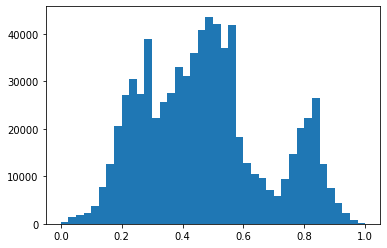

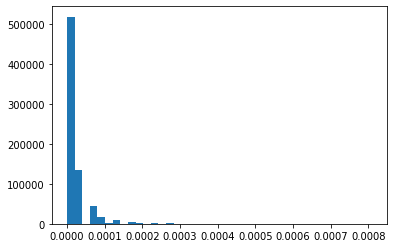

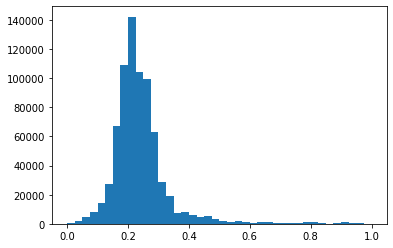

In [214]:
for i in range(template_features.shape[1]):
    plt.hist(np.array(template_features[:,i].data).flat, bins = 40)
    plt.show()

In [215]:
#get a hist of sector size

In [216]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


8695.13671875


In [217]:
def ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss ):
    data = HeteroData()
    #add input data
    data['phylonodes_up'].x = torch.tensor( subfeatures )
    data['phylonodes_down'].x =torch.tensor( subfeatures )
    data['sectornode'].x =torch.tensor(  np.zeros((1,1)) )
    #up down fitch net
    data['phylonodes_up', 'phylolink_up', 'phylonodes_up'].edge_index = torch.tensor(connect_up ,  dtype=torch.long )
    data['phylonodes_down', 'phylolink_down', 'phylonodes_down'].edge_index = torch.tensor(connect_down ,  dtype=torch.long )             
    data['phylonodes_up', 'phylolink_up_down', 'phylonodes_down'].edge_index = torch.tensor( sub_diag ,  dtype=torch.long )
    data['phylonodes_down', 'phylolink_down_up', 'phylonodes_up'].edge_index = torch.tensor( sub_diag ,  dtype=torch.long )

    #pooling connections
    data['phylonodes_down', 'informs', 'sectornode'].edge_index = torch.tensor(overview ,  dtype=torch.long )
    data['phylonodes_up', 'informs', 'sectornode'].edge_index = torch.tensor(overview ,  dtype=torch.long )

    #pooling connections
    data['sectornode',  'informs', 'phylonodes_down' ].edge_index = torch.tensor(overview_rev,  dtype=torch.long )
    data['sectornode',  'informs', 'phylonodes_up'].edge_index = torch.tensor(overview_rev ,  dtype=torch.long )
    #categories are intra or interprotein contacts or nothing
    if intra == True:
        cateforical = np.array([0,1])
    else:
        cateforical = np.array([1,0])
    data['phylonodes_down'].y =torch.tensor( np.ones((subfeatures.shape[0],1) ) *toss ,  dtype=torch.long )
    data['phylonodes_up'].y =torch.tensor( np.ones((subfeatures.shape[0],1)) * toss ,  dtype=torch.long )
    #todo change to categorical
    data['sectornode'].y =torch.tensor(  np.ones((1,1))*toss  ,  dtype=torch.long )
    data = T.AddSelfLoops()(data)
    #data = T.NormalizeFeatures()(data)
    return data

def yield_tosses(posi_percent = .5):
    while True:
        toss = scipy.stats.bernoulli.rvs(posi_percent, loc=0, size=1, random_state=None)
        yield toss

def gen_sample(toss , col1 , col2 , pairs, AA_tensor, NT_tensor, connectmat_diag, 
    template_features  ,  posi_percent = .5 , nsamples = 30 , min_nodes = 10,  q = None , iolock= None,  
    verbose = False, loop= True , sectors_chunk = True , intra = True , subsample = False ):
    #generate a few samples of subgraphs from a column pair
    label = np.ones((1,1))*toss
    #select coev features
    if verbose == True:
        print( 'col1',AA_tensor[:,col1,:] )
        print( 'col2', AA_tensor[:,col2,:] ) 
    nodeAAfeatures = sparse.stack( [AA_tensor[:,col1,:] ,AA_tensor[:,col2,:] ] , axis = 2  ).reshape((AA_tensor.shape[0],-1))
    nt_cols = []
    for pos in [0,1,2]: 
        nodeNTfeatures = sparse.stack( [NT_tensor[:,col1+ pos,:] ,NT_tensor[:, col2+ pos,:] ] , axis = 2)
        nt_cols.append(nodeNTfeatures.reshape((nodeNTfeatures.shape[0],-1)) )
    available_rows = list(np.where( nodeAAfeatures.sum(axis=1) > 0 )[0])
    if verbose == True:
        print(nodeAAfeatures)
        print(available_rows)
    features = [nodeAAfeatures] + nt_cols 
    features = [f.to_scipy_sparse() for f in features]
    nodefeatures = sparse.COO(scipy.sparse.hstack( features ))
    #slice the features into sectors and yield sectors
    samples =[]
    #select a row where the is at least 1 mutation
    #rows = gen_graphchunk(connectmat, start_node=random.choice(available_rows) , niter = 10 , verbose = False, plotmat=False)
    rows, connectmat = find_paths(AA_tensor[:,col1,:],AA_tensor[:,col2,:])
    #node features
    subfeatures = np.hstack( [ template_features[rows,:].todense() , nodefeatures[rows,:].todense() ] )
    
    
    #phylonode connections
    
    connect_up = sparse2pairs(connectmat)
    connect_down = sparse2pairs(connectmat.T)
    sub_diag = connectmat_diag[rows,:]
    sub_diag = sub_diag[:,rows]
    sub_diag = sparse2pairs(sub_diag)
    
    #aggregator node
    overview = scipy.sparse.lil_matrix( (subfeatures.shape[0], 2 ) )
    overview[:,0] = 1
    overview_rev = sparse2pairs(overview.T)
    overview = sparse2pairs(overview)
    data = ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss )
    return data


def check_pts(col, allcols):
    for i in range(30):
        if i+col in allcols:
            return i+col
        if -i+col in allcols:
            return -i+col
    else:
        return None

def create_data_updown_transitions_single( pairs, AA_tensor, NT_tensor, connectmat_diag, 
    template_features, allcols,  posi_percent = .5 , nsamples = 30 , min_nodes = 100,  q = None , iolock= None,  verbose = True, loop= True , sectors_chunk = True ):
    #map
    tossgen = yield_tosses(posi_percent)
    for toss in tossgen:
        if toss == 0:
            col1 = random.choice(allcols)
            col2 = col1
            while col1 == col2 and (col1,col2) not in pairs:
                col2 = random.choice(allcols)
            labels = np.zeros((template_features.shape[0],))           
        else:
            #positive sample
            pairindex = random.randint(0,pairs[0].shape[0]-1)
            pairtuple = ( pairs[0][pairindex] , pairs[1][pairindex])
            while True:
                col1 = pairtuple[0]
                col1 = check_pts(col1, allcols)
                col2 = pairtuple[1]
                col2 = check_pts(col2, allcols)
                if col1 and col2 and col1!= col2:
                    break
                pairindex = random.randint(0,pairs[0].shape[0]-1)
                pairtuple = ( pairs[0][pairindex] , pairs[1][pairindex])
        if verbose == True:
            print(toss)
            print(col1, col2)
        yield  gen_sample( toss , col1 , col2 ,  pairs, AA_tensor, NT_tensor , connectmat_diag, template_features ,  posi_percent = .5 ,  q = None , iolock= None,  verbose = verbose, loop= True  ) 
        

In [218]:
#create reduced alphabet mapping
#AA transitions

murphy12 = [('L','V','I','M'), ('C'), ('A'), ('G'), ('S','T'), ('P'), ('F','Y'), ('W'), ('E','Q'), ('D','N'), ('K','R'), ('H') ]
murphy12 = { c:i for i,cset in enumerate(murphy12) for c in cset   }
print('murphy12',murphy12)

ProteinAlphabet = [ 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y' ]
allowed_AA_transitions = [ c1+c2 for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2]

print('ntransitions' ,len(set(allowed_AA_transitions)))
new_transitions = [ (murphy12[c1],murphy12[c2]) for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2  ]
new_transitions = { tup:i for i,tup in enumerate(set(new_transitions)) }
print('nmurphy transitions' , len(set(new_transitions)))
print(allowed_AA_transitions[0:100] , '...etc...')
transitiondict_AA = {  c : i  for i,c in enumerate( allowed_AA_transitions )  }
rev_transitiondict_AA = dict( zip(transitiondict_AA.values(), transitiondict_AA.keys()))


murphy12 {'L': 0, 'V': 0, 'I': 0, 'M': 0, 'C': 1, 'A': 2, 'G': 3, 'S': 4, 'T': 4, 'P': 5, 'F': 6, 'Y': 6, 'W': 7, 'E': 8, 'Q': 8, 'D': 9, 'N': 9, 'K': 10, 'R': 10, 'H': 11}
ntransitions 380
nmurphy transitions 138
['AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AK', 'AL', 'AM', 'AN', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AV', 'AW', 'AY', 'CA', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CV', 'CW', 'CY', 'DA', 'DC', 'DE', 'DF', 'DG', 'DH', 'DI', 'DK', 'DL', 'DM', 'DN', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DV', 'DW', 'DY', 'EA', 'EC', 'ED', 'EF', 'EG', 'EH', 'EI', 'EK', 'EL', 'EM', 'EN', 'EP', 'EQ', 'ER', 'ES', 'ET', 'EV', 'EW', 'EY', 'FA', 'FC', 'FD', 'FE', 'FG', 'FH', 'FI', 'FK', 'FL', 'FM', 'FN', 'FP', 'FQ', 'FR', 'FS', 'FT', 'FV', 'FW', 'FY', 'GA', 'GC', 'GD', 'GE', 'GF'] ...etc...


In [219]:
print(pairs[0].shape)

(5168,)


In [220]:
#reduce alphabet to reduce AA transition dimensionality
def restrictAA_transitions(AAmat, rev_transitiondict_AA, murphy12 , new_transitions , restricted_transitions = 138 , verbose = True ):
    restricted = None
    for z in range(AAmat.shape[2]):
        
        transition = rev_transitiondict_AA[z]
        new_transition = new_transitions[ (murphy12[transition[0]] , murphy12[transition[1]] )]
        data = AAmat[:,:,z].data
        coords =  AAmat[:,:,z].coords
        if coords.shape[1]>0:    
            newcoords = np.vstack( [coords, np.ones((1,coords.shape[1]))*new_transition]).astype('int')
            if restricted is not None:
                restricted  += sparse.COO( coords =  newcoords , data = data
                                            , shape = (AAmat.shape[0] , AAmat.shape[1] , restricted_transitions )  )
            else:
                restricted  =  sparse.COO( coords = newcoords , data = data  
                                            , shape = (AAmat.shape[0] , AAmat.shape[1] , restricted_transitions )  )
    return restricted


In [221]:
###rewrite codon compilation for sparse
import sparse

restrictAA = False
collapseMats = True
buildstructmats = False
if buildstructmats == True:
    def retcodons( AAmat , NTmat, qstart, qend, verbose = True ):
        #aa mutations for each pos
        AAmat_sub = sparse.stack(  [ AAmat[ : , codon:codon+2 , : ].sum(axis = 1) for codon in range(qstart-1, qend-1 , 3 )  ] , axis = 1 )    
        #add the frames for each in a stack 
        if verbose == True:
            print('done AA')
        NTmat_sub = sparse.stack([  sparse.stack( [ NTmat[:, codon + frame , : ] for frame in [0,1,2] ] , axis = 1 )  for codon in range(qstart-1, qend-1 , 3 ) ] , axis = 1)
        if verbose == True:
            print('done NT')
        return AAmat_sub , NTmat_sub
    print(annotation)
    structmats = {}
    start_stop ={}
    print(nucleotide_mutation)
    print(AA_mutation)

    for i,row  in annotation.iterrows():
        print(row.qstart)
        if row.struct not in structmats:
            structmats[row.struct]={}    
        if (row.qstart , row.qend) not in start_stop:
            structmats[row.struct][row.chain ] = retcodons(AA_mutation, nucleotide_mutation  , row.qstart , row.qend)
            if restrictAA == True:
                structmats[row.struct][row.chain ] = ( restrictAA_transitions(structmats[row.struct][row.chain ][0] , rev_transitiondict_AA, murphy12 , new_transitions , restricted_transitions = 138 ) , structmats[row.struct][row.chain ][1] )
            elif collapseMats == True:
                endshapeAA = list(structmats[row.struct][row.chain ][0].shape)
                endshapeAA[2] = 1
                endshapeNT = list(structmats[row.struct][row.chain ][1].shape)
                endshapeNT[3] = 1
                structmats[row.struct][row.chain ] = ( structmats[row.struct][row.chain ][0].sum(axis = 2).reshape(endshapeAA) , structmats[row.struct][row.chain ][1].sum(axis = 3).reshape(endshapeNT) )
            start_stop[(row.qstart , row.qend)] = structmats[row.struct ][ row.chain ]
        else: 
            structmats[row.struct][row.chain ] = start_stop[(row.qstart , row.qend)]
    with open('structmats.pkl' , 'wb') as structout:
        structout.write( pickle.dumps( structmats ))
else:
    with open('structmats.pkl' , 'rb') as structout:
        structmats= pickle.loads(  structout.read())

In [222]:
#looking for more than 1 position
submat = structmats['7DZW']['C'][0]
submat = submat.sum(axis = 2)
allcols = list(np.where( submat.sum(axis = 0 ) > 10 )[0])
print(len(set(allcols)))

219


In [223]:
#using networkx to mutation tree
import networkx as nx
import scipy 
G = nx.DiGraph()
G.add_edges_from([[ e[0],e[1] ] for e in list(zip(list(graphmat.col), list(graphmat.row))) ])
print(G)

DiGraph with 741326 nodes and 741325 edges


In [224]:
def find_paths(col1,col2, verbose =False):
    both = col1+col2
    #both = both.sum(axis=1)
    
    nodefilter = list(set(both.coords[0]))
    if verbose == True:
        print(nodefilter)
    paths = [ nx.ancestors(G, source= n ) for n in nodefilter ]
    allnodes = set([])
    for p in paths:
        allnodes = allnodes.union(p)
    allnodes = list(allnodes)
    #extract subgraph
    subG = G.subgraph(allnodes)
    subG = nx.DiGraph(subG)
    collapsed = [ n for n, d in subG.degree() if d == 2 ]
    S = G.subgraph(collapsed)
    S = nx.Graph(S)

    remove = []
    for c in nx.connected_components(S):
        ends = [ n for n, d in S.subgraph(c).degree() if d == 1 ]
        #add edge in subG
        if len( ends ) == 2:
            subG.add_edge(ends[1], ends[0])
            remove += [ n for n, d in S.subgraph(c).degree() if d != 1 ]
        #remove the nodes in connected component from SubG
    remove = set(remove)
    kept = [ n for n in subG.nodes() if n not in remove ]
    subG = subG.subgraph(kept)
    #collapse nodes w degree 2
    if verbose == True:
        nx.draw(subG, pos=nx.spring_layout(subG))
        plt.show()
        print(G , subG , len([c for c in nx.connected_components(nx.Graph(subG))]))
        
    return sorted( list ( subG.nodes())) , nx.adjacency_matrix(subG)

<COO: shape=(741326,), dtype=float64, nnz=16, fill_value=0.0> <COO: shape=(741326,), dtype=float64, nnz=25, fill_value=0.0>
[29570, 148994, 526083, 636292, 501770, 411668, 661143, 473881, 21019, 140445, 113574, 559398, 506792, 645039, 430388, 265017, 122559, 229570, 220487, 198344, 696649, 667722, 559435, 659403, 265553, 670161, 305235, 367191, 82522, 560865, 582372, 144358, 490086, 503911, 630502, 649319, 163694, 714225, 295411, 67706, 702587]


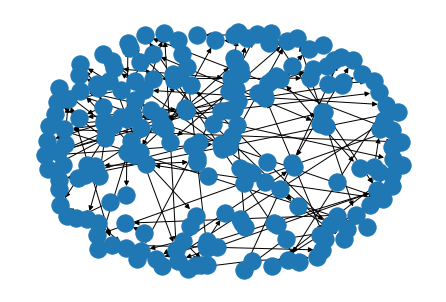

DiGraph with 741326 nodes and 741325 edges DiGraph with 214 nodes and 215 edges 1
<class 'scipy.sparse._csr.csr_matrix'>   (0, 2)	1
  (4, 16)	1
  (5, 6)	1
  (6, 7)	1
  (6, 82)	1
  (7, 70)	1
  (9, 24)	1
  (10, 11)	1
  (10, 160)	1
  (12, 13)	1
  (14, 15)	1
  (15, 14)	1
  (15, 17)	1
  (17, 18)	1
  (17, 124)	1
  (19, 10)	1
  (20, 21)	1
  (20, 114)	1
  (21, 22)	1
  (21, 134)	1
  (22, 92)	1
  (24, 25)	1
  (24, 53)	1
  (26, 27)	1
  (26, 81)	1
  :	:
  (194, 195)	1
  (195, 4)	1
  (196, 155)	1
  (197, 23)	1
  (197, 200)	1
  (199, 189)	1
  (199, 201)	1
  (202, 55)	1
  (202, 203)	1
  (203, 58)	1
  (203, 207)	1
  (204, 200)	1
  (204, 208)	1
  (205, 198)	1
  (205, 206)	1
  (207, 184)	1
  (209, 169)	1
  (209, 210)	1
  (210, 8)	1
  (210, 211)	1
  (211, 5)	1
  (212, 3)	1
  (212, 11)	1
  (213, 1)	1
  (213, 18)	1


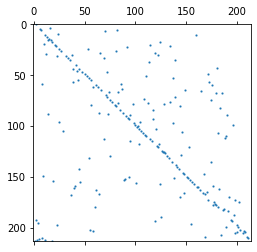

In [225]:
c1 = 991 
c2 = 750
col1 = submat[: , c1]
col2 = submat[: , c2]
print(col1,col2)
paths,adj = find_paths(col1,col2, verbose = True)
print((type(adj)), adj)

plt.spy(adj , markersize = 1)
plt.show()

In [226]:
print(structmats)

{'7DZW': {'C': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>), 'B': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>), 'A': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>)}}


In [227]:
print(pairs[0].shape,pairs[1].shape)

(5168,) (5168,)


In [228]:
template_features = sparse.COO(template_features)
sampleGEN = create_data_updown_transitions_single( pairs, structmats['7DZW']['C'][0] , structmats['7DZW']['C'][1] ,  connectmat_diag, 
 template_features , allcols, posi_percent = .5 , nsamples = 10 , min_nodes = 10,  q = None , iolock= None,  verbose = False, loop= True , sectors_chunk = True )

In [229]:
print( next( sampleGEN ))

HeteroData(
  phylonodes_up={
    x=[576, 23],
    y=[576, 1]
  },
  phylonodes_down={
    x=[576, 23],
    y=[576, 1]
  },
  sectornode={
    x=[1, 1],
    y=[1, 1]
  },
  (phylonodes_up, phylolink_up, phylonodes_up)={ edge_index=[2, 1159] },
  (phylonodes_down, phylolink_down, phylonodes_down)={ edge_index=[2, 1159] },
  (phylonodes_up, phylolink_up_down, phylonodes_down)={ edge_index=[2, 576] },
  (phylonodes_down, phylolink_down_up, phylonodes_up)={ edge_index=[2, 576] },
  (phylonodes_down, informs, sectornode)={ edge_index=[2, 576] },
  (phylonodes_up, informs, sectornode)={ edge_index=[2, 576] },
  (sectornode, informs, phylonodes_down)={ edge_index=[2, 576] },
  (sectornode, informs, phylonodes_up)={ edge_index=[2, 576] }
)


/tmp/9850443/ipykernel_5481/2804683713.py:102: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  while col1 == col2 and (col1,col2) not in pairs:


In [230]:
reload = False
ntrain = 1000
ntest = 500

In [231]:
trainset = './trainset.pkl'

if reload == True:
    with open( trainset , 'rb' ) as datain:
        train = pickle.loads( datain.read())
else:
    train = []
    
testset = './testset.pkl'
if reload == True:
    with open( testset , 'rb' ) as datain:
        test = pickle.loads( datain.read())
else:
    test = []

In [232]:
print(len(train), len(test))

0 0


In [233]:
for i in range(ntrain):
    train.append(next( sampleGEN ))

/tmp/9850443/ipykernel_5481/2804683713.py:102: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  while col1 == col2 and (col1,col2) not in pairs:


In [234]:
with open( trainset , 'wb' ) as datain:
    datain.write( pickle.dumps( train ) )

In [235]:
for i in range(ntrain):
    test.append(next( sampleGEN ))

/tmp/9850443/ipykernel_5481/2804683713.py:102: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  while col1 == col2 and (col1,col2) not in pairs:


In [236]:
with open( testset , 'wb' ) as datain:
    datain.write( pickle.dumps( test ) )
    

In [237]:
with open( trainset , 'rb' ) as datain:
    train = pickle.loads( datain.read())

In [238]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)

9604.2421875


In [239]:
print(structmats)

{'7DZW': {'C': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>), 'B': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>), 'A': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>)}}


In [254]:
print(subthresh_connected['7DZW'])

{'C': array([[28., 19., 19., ...,  0.,  0.,  0.],
       [19., 34., 31., ...,  0.,  0.,  0.],
       [19., 31., 39., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 19., 18., 16.],
       [ 0.,  0.,  0., ..., 18., 20., 16.],
       [ 0.,  0.,  0., ..., 16., 16., 17.]], dtype=float32), ('A', 'B'): array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), ('A', 'C'): array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  9.,  8.,  7.],
       [ 0.,  0.,  0., ...,  8., 10.,  9.],
       [ 0.,  0.,  0., ...,  7.,  9., 11.]], dtype=float32)}


In [255]:
from torch_geometric.nn import HeteroConv , SAGEConv, Linear , ResGatedGraphConv , GATv2Conv , TransformerConv , MFConv , FiLMConv 
import torch_geometric.transforms as T
#"sum", "mean", "min", "max"
#without sectornode
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        self.lins =  torch.nn.ModuleList()
        self.lins2 =  torch.nn.ModuleList()
        
        for i in range(num_layers):
            conv = HeteroConv({
                ('phylonodes_up', 'phylolink_up', 'phylonodes_up'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down', 'phylonodes_down'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down_up', 'phylonodes_up'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'phylolink_up_down', 'phylonodes_down'):TransformerConv((-1,-1),  int( hidden_channels) ), 
                ('phylonodes_down', 'informs', 'sectornode'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'informs', 'sectornode'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('sectornode', 'informs', 'phylonodes_down'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('sectornode', 'informs', 'phylonodes_up'):TransformerConv((-1,-1),  int( hidden_channels) ),
            } , aggr='sum')
            self.convs.append(conv)
            for vectype in  ['phylonodes_up', 'phylonodes_down' , 'sectornode'  ]:
                lin1 = Linear(-1 , int( hidden_channels))
                self.lins.append( lin1 )
                
            print( 'hidden units' , int( hidden_channels) )
            print( 'layer' , i )

        for vectype in ['phylonodes_up', 'phylonodes_down' , 'sectornode' ]:
            lin2 = Linear(-1 , out_channels)
            self.lins2.append( lin2 ) 

    
    def forward(self, x_dict, edge_index_dict):
        lins = iter(self.lins)
        for i,conv in enumerate(self.convs):
            x_dict = conv(x_dict , edge_index_dict)
            x_dict = {key:( F.dropout(x , p = .1 , training = self.training ) if 'phylo' in key else x ) for key, x in x_dict.items()}
            for key, x in x_dict.items():
                x_dict[key] = next(lins)(x)
        lins2 = iter(self.lins2)
        for key, x in x_dict.items():
            x_dict[key] =  next(lins2)(x)
        return {key: F.tanh(x) for key, x in x_dict.items()}
        #return x_dict
model = HeteroGCN(hidden_channels= 20 , out_channels=1, num_layers=5 )
model = model.double()
model = model.to(device)

hidden units 20
layer 0
hidden units 20
layer 1
hidden units 20
layer 2
hidden units 20
layer 3
hidden units 20
layer 4


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001)
with torch.no_grad():  # Initialize lazy modules.
    data =next( sampleGEN )
    data = data.to(device)
    out = model(data.x_dict , data.edge_index_dict)

In [261]:
import warnings
from torch_geometric.loader import DataLoader
lastauc = 0
epochs = 1000
#iterate over structs
model = model.to(device)
calc_metrics_overds = True
def calc_metrics(truths,preds,label = ''):
    truth = np.hstack(truths).ravel()
    predy = np.hstack(preds).ravel()
    fpr, tpr, _ = roc_curve(  truth  ,predy )
    auc_s = auc(fpr, tpr)
    print(label,auc_s)

loader = DataLoader(train, batch_size  = 20 )
testloader = DataLoader(test, batch_size  = 20 )

print('done init')
truths = []
preds = []
truths_n = []
preds_n = []
losses1 =[]
losses2 = []
losses3 = []

count = 0 
for e in range(epochs):
    for k,data in enumerate(loader):
        count += 1
        if count % 100 == 0 :
            print('losses', np.mean(losses1), np.mean(losses2), np.mean(losses3) )
            losses1 = []
            losses2 = []
            losses3 = []
            if calc_metrics_overds == True and count > 0 and count%200 == 0:
                print('metrics')
                model.eval()
                truths = []
                preds = []
                truths_n = []
                preds_n = []
                for testdata in testloader:
                    testdata = testdata.to(device)
                    pred = model(testdata.x_dict ,testdata.edge_index_dict)
                    truth = testdata['sectornode']['y'][:,0].to('cpu').detach().numpy()
                    predy =  pred['sectornode'][:,0].to('cpu').detach().numpy()
                    truths.append(truth)
                    preds.append(predy)

                    truth_n = testdata['phylonodes_down']['y'][:,0].to('cpu').detach().numpy()
                    pred_n =  pred['phylonodes_down'][:,0].to('cpu').detach().numpy()
                    truths_n.append(truth_n)
                    preds_n.append(pred_n)
                calc_metrics(truths,preds,label = 'sectornode')
                calc_metrics(truths_n,preds_n,label = 'phylonodes')   
        data = data.to(device)            
        out = model(data.x_dict ,data.edge_index_dict)
        optimizer.zero_grad()
        loss1 =  F.mse_loss(out['phylonodes_up'], data['phylonodes_up'].y.double())
        loss2 =  F.mse_loss(out['phylonodes_down'], data['phylonodes_down'].y.double())
        loss3 =  F.mse_loss(out['sectornode'], data['sectornode'].y.double())
        loss = loss3 + loss1 + loss2
        loss.backward()
        optimizer.step()
        losses3.append(float(loss3.to('cpu')))
        losses2.append(float(loss2.to('cpu')))
        losses1.append(float(loss1.to('cpu')))
    

done init
losses 0.1414994085434119 0.1420910454330127 0.14947403409662804
losses 0.13932283985155813 0.13980289454482492 0.1507969605425751
metrics
sectornode 0.8192749375360369
phylonodes 0.8436710196326246


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.15833387252333453 0.15792209605782823 0.1729558407535908
losses 0.1451918111443948 0.1452159001134491 0.15801555720070903
metrics
sectornode 0.8275614228970467
phylonodes 0.8457082829224608


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13549682146844935 0.13573074056511564 0.14735731240246527
losses 0.13068378341307618 0.13091486333445304 0.14340794270058363
metrics
sectornode 0.8344464731885451
phylonodes 0.8455459185269567


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12791935050504705 0.12807042244730257 0.1417634982058548
losses 0.12305716423165586 0.12326832194250884 0.13742654379790634
metrics
sectornode 0.8339679832148119
phylonodes 0.8450805600589757


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11990526134332369 0.12017084626958148 0.13451338199887275
losses 0.1227167771533878 0.12287961156273665 0.13655654280934298
metrics
sectornode 0.8353814305849191
phylonodes 0.8556943502170825


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13516770842980513 0.1353576870167936 0.14637078140583626
losses 0.13142498189339305 0.13167198479135864 0.14334971204759847
metrics
sectornode 0.8315515087449549
phylonodes 0.8525314619450344


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13646704415482597 0.13680072300452537 0.14551221456682492
losses 0.12741572342043928 0.12757070277680985 0.1382456788525662
metrics
sectornode 0.8285864725478891
phylonodes 0.8431296372830304


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12518435550991897 0.12553174756118907 0.1380590832579063
losses 0.11974284301361462 0.11998213903356918 0.13141499119121922
metrics
sectornode 0.8450172977128579
phylonodes 0.8598487389922396


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11884860194565394 0.11911723082335816 0.13169453626028302
losses 0.11674216021289487 0.11694836427837275 0.12902838762876692
metrics
sectornode 0.8358378980075597
phylonodes 0.8557065803336392


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11522625946292318 0.11571467670878073 0.12915311555451228
losses 0.11421080486831162 0.11458090629016375 0.12767270543854117
metrics
sectornode 0.8413655583317317
phylonodes 0.8582724386493028


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11575998365514659 0.11594489112849773 0.12722383512027022
losses 0.11787987065139839 0.1181356497212163 0.12976682432323286
metrics
sectornode 0.8100334742776603
phylonodes 0.8275071561178285


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12184112208635753 0.12246865608218638 0.13284235727241944
losses 0.12033099600566255 0.12101035152827924 0.1322079407922714
metrics
sectornode 0.8336376449484272
phylonodes 0.8573906591187507


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1270375663655586 0.12750633902288055 0.14009238585948874
losses 0.11715793613357998 0.11755306296880598 0.12340140201010716
metrics
sectornode 0.862345041322314
phylonodes 0.8778289132836795


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13135463152283564 0.13158591749785686 0.13405532566987302
losses 0.1264893909766587 0.12653507861466676 0.1303073658564108
metrics
sectornode 0.8426008232430009
phylonodes 0.8478153940808345


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11870074406597354 0.11906450902588661 0.12583679154739622
losses 0.1258197756277348 0.12583246757981437 0.1281197616378945
metrics
sectornode 0.8440182747133064
phylonodes 0.8501754274011954


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11370789852753108 0.11383247222854034 0.12423821867867987
losses 0.10502367503373437 0.10524306885569266 0.11548137385804852
metrics
sectornode 0.8516100486898585
phylonodes 0.8668376676338652


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11364022015480629 0.11392931334458187 0.12394279275109359
losses 0.10433881707242719 0.10445120788814144 0.11350673549422279
metrics
sectornode 0.8533918732782368
phylonodes 0.864447089315675


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10419843210650873 0.1045778794730258 0.11388998132732846
losses 0.10892821132390951 0.10928928516832506 0.11412312692558219
metrics
sectornode 0.8505970113396117
phylonodes 0.85093990208989


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09546937728206965 0.09565730367543987 0.10683026139739585
losses 0.10380813372519705 0.10403362174618921 0.11691690689555577
metrics
sectornode 0.8729659170991095
phylonodes 0.8783916354587372


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09206202544572095 0.09230609622442489 0.1016307428663963
losses 0.1259426416547264 0.12578798281504047 0.1386646602680629
metrics
sectornode 0.8566992600422834
phylonodes 0.8619687890997672


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11972175127690184 0.11990826619858996 0.12810470093679185
losses 0.11242828265539564 0.11258022611535594 0.1156382127678882
metrics
sectornode 0.8583269267730155
phylonodes 0.8710782501823142


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10940330761212097 0.10972576294041732 0.11657768326430457
losses 0.10233757649284687 0.1025506413974707 0.1079544395889093
metrics
sectornode 0.8718427669934014
phylonodes 0.8793127875076163


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10212129330988338 0.10256059053630333 0.10781457181428392
losses 0.09588995589774514 0.09608543950810589 0.10202664163703044
metrics
sectornode 0.8539444391056441
phylonodes 0.8632891136712258


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0949921224516958 0.09516849978006053 0.10177678616674272
losses 0.1027590744061401 0.10320555270444821 0.1067792488418038
metrics
sectornode 0.8562487987699403
phylonodes 0.8702430250292387


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09114362336845018 0.09138691824596769 0.09692200480386956
losses 0.08564885317257319 0.08592114540467928 0.0965521527660387
metrics
sectornode 0.8651278909603434
phylonodes 0.870831202752302


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09165652580900811 0.09185060338555234 0.10232566111834465
losses 0.08700924306198875 0.08703185886414051 0.09435345440613986
metrics
sectornode 0.8683151547184317
phylonodes 0.8780218939922873


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08907399252662311 0.08923956960381968 0.0981392359455154
losses 0.11682316208914656 0.11774126688554293 0.1337331486235804
metrics
sectornode 0.829919837914024
phylonodes 0.8347629445076679


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10410685271917891 0.1045667825687358 0.11573294047826957
losses 0.10395699063524125 0.10425566278617268 0.11241945383231876
metrics
sectornode 0.859876513549875
phylonodes 0.8794352415722914


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0964290478027809 0.09669811716619085 0.10605416629254837
losses 0.08936225957641364 0.08955497984451932 0.10046924557120607
metrics
sectornode 0.8532317092702929
phylonodes 0.8661077275145856


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09561654518471802 0.09607399977705791 0.10671051496378606
losses 0.08843071364596217 0.08872843574552576 0.1006803227424951
metrics
sectornode 0.8593419661733616
phylonodes 0.8731752218344898


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08529352091981746 0.08545778060022485 0.09486641336212731
losses 0.08957138733074002 0.0898238805868098 0.10213450357899331
metrics
sectornode 0.8720489781536293
phylonodes 0.8763078656282031


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08883933723940388 0.08901774029888716 0.0963196366638576
losses 0.08866317888877724 0.0889659153140312 0.09718299302607844
metrics
sectornode 0.8593760010250497
phylonodes 0.8796860874500044


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09598968473323957 0.0962683257282543 0.10464476720379336
losses 0.09021386974297792 0.09038951309036061 0.09368581078444821
metrics
sectornode 0.8715284451278108
phylonodes 0.8746363450151637


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0873561960388125 0.08738533339721039 0.0949791541863721
losses 0.10577731195478736 0.1059839172755051 0.11003548366638242
metrics
sectornode 0.8333353353834325
phylonodes 0.8308285399284551


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10210747655964307 0.10223701315882519 0.10727834488796781
losses 0.09382480081709473 0.0941729144730119 0.09958025272253396
metrics
sectornode 0.8501665705682621
phylonodes 0.8583298419170828


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09053338649753301 0.09077872945567936 0.09429265222598503
losses 0.09401820288158297 0.09424688580807197 0.09696235295525481
metrics
sectornode 0.8639747101031456
phylonodes 0.8800278430615395


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08672490369311273 0.08687118079597513 0.0902754814304215
losses 0.08501181420841433 0.0854086652086067 0.0885596980179256
metrics
sectornode 0.8758068261900185
phylonodes 0.8803417368287384


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07840017618916029 0.07863683635856117 0.08386909086131217
losses 0.07599858125622343 0.07609080419515922 0.08060252318019483
metrics
sectornode 0.8872785732590173
phylonodes 0.8933506895076085


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0773191666616835 0.07745770745687468 0.08040983654053009
losses 0.09682932747624662 0.09696603702023103 0.10215421598269478
metrics
sectornode 0.8760130373502467
phylonodes 0.8803685769645715


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08247852230629578 0.08260277291723654 0.08400283662445743
losses 0.07718667130612729 0.0772806993463553 0.08086064709840342
metrics
sectornode 0.8681790153116791
phylonodes 0.8663238451121619


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10076411995786864 0.10050803105432855 0.10051162967633895
losses 0.1128818352167509 0.11313344217194832 0.1230304879330226
metrics
sectornode 0.8477460919982062
phylonodes 0.8617745971476402


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09364002651888205 0.0939595894040405 0.09928742825132905
losses 0.09290842900733969 0.09322112026991755 0.09782605903739118
metrics
sectornode 0.8594140399769364
phylonodes 0.8703456605252852


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.090109480327148 0.09031264803257581 0.08845139599309784
losses 0.09303194542640479 0.0933982785865614 0.0959914600921908
metrics
sectornode 0.8680368697546287
phylonodes 0.8773336328646646


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/users/dmoi/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/9850443/ipykernel_5481/3570583429.py", line 58, in <module>
    out = model(data.x_dict ,data.edge_index_dict)
  File "/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/9850443/ipykernel_5481/403284614.py", line 40, in forward
    x_dict = conv(x_dict , edge_index_dict)
  File "/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch_geometric/nn/conv/hetero_conv.py", line 125, in forward
    out = conv((x_di

TypeError: object of type 'NoneType' has no len()

In [ ]:
        #load subgraphs
        #train_input_nodes = #######
        #train_loader = HGTLoader(data , num_samples=[1024] * 4, shuffle=True, input_nodes=train_input_nodes, **kwargs)
        #for trainsample in train_loader:
            #train here
            
            
            
    #for labels in [ aglo_l]:
    #    l,c = np.unique(labels, return_counts= True)
        print(i)
        print(chain)
        #categorical-> direct, indirect or no contact
        
        
        
        
        
        
        if i == 0 :
            total_thresh = subthresh_thresh['7DZW'][chain]
            total_connect = subthresh_connected['7DZW'][chain]

            #green, oranges, reds = struct_hits( labels, threshmat , connectmat , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10)
        else:
            total_thresh += subthresh_thresh['7DZW'][chain]
            total_connect += subthresh_connected['7DZW'][chain]
            
        # find nonzero
        # zeroed entries are the complement
        #sample each fraction randomly
        ### testing loop ####
        if epoch % 100 == 0:
            ROC_curve_single(y_test, y_pred_grd)
        
        ### save based on performance
        
        
            
proj_greens, proj_oranges, proj_reds = struct_hits_filter( AATF, labels, total_thresh , total_connect , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10 )
#proj_greens, proj_oranges, proj_reds = struct_hits(  labels, total_thresh , total_connect , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10 )

print(proj_greens, proj_oranges, proj_reds )

In [45]:
#use for lsh encoding
def retcodon_mats(annotation , AAmat , plt = False):
    positions = set([])
    AAmat = scipy.sparse.csc_matrix(AAmat)
    print('converted')
    slices = []
    for i,r in annotation.iterrows():
        if (r.qstart-1, r.qend-1) not in slices:        
            slices.append((r.qstart-1, r.qend-1))
    count = 0
    for start,end in slices:
        codonmat = np.zeros(( AAmat.shape[0] , int((end - start + 10 ) /3) ) )
        for j,codon in enumerate(range(start-1, end-1 , 3 )):
            cols = np.sum( AAmat[:, codon:codon+2] , axis = 1 )
            codonmat[:,count] = cols.ravel()
            count+=1
            if count%500 == 0 and count >0:
                print(count/codonmat.shape[1])
        yield codonmat 
        
        if plt == True:
            print(np.sum(codonmat))
            plt.figure(figsize=(20,20))
            plt.spy(codonmat, markersize= .5)
            plt.show()

In [46]:
from scipy.spatial import distance_matrix

def check_point(contactsx , contactsy, ptx,pty, radius = 2 , verbose = False):
    #find non zero distance_matrixpts
    for center_x, center_y, in zip(contactsx,contactsy):
        if (ptx - center_x)**2 + (pty - center_y)**2 < radius**2:
            if verbose == True:
                print(ptx,pty,center_x, center_y)
                print('left', (ptx - center_x)**2 + (pty - center_y)**2 )
                print( 'right', radius**2 )
            return True
    return False


    
def struct_hits_filter( pairs , threshmat, connectmat , verbose = False , radius = 5 ):
    subthresh = threshmat
    plt.figure(figsize=(20,20) )
    

    plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , c = 'b', marker= 'o' , alpha = .025,  s = 50)
    #red and green plt
    reds =[]
    oranges=[]
    greens =[]
    nz_pts = np.array(pairs)
    print(i)
    mask = copy.deepcopy(subthresh)
    
    structpoints = np.vstack([np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]] ).T
    print(structpoints)
    d = distance_matrix(structpoints, np.array(pairs) )
    
    green = [ True if np.amin(d[:,i]) < radius else False for i in  range(d.shape[1]) ]
    #green = np.array( dask.compute(*green) )
    green = np.array(green)
    if len(green)>0:
        if connected is not None:
            structpoints = np.vstack([np.nonzero(connectmat)[0] ,np.nonzero(connectmat)[1]] ).T
            d = distance_matrix(structpoints, np.array(pairs) )
            orange = [ True if np.amin(d[:,i]) < radius else False for i in  range(d.shape[1]) ]
    
            #orange = [ check_point(list(np.nonzero(connectmat)[0]) , list(np.nonzero(connectmat)[1]), ptx , pty,radius = radius )  for ptx,pty in nz_pts ]

            #orange = np.array(dask.compute(*orange) )
            both = list(np.logical_and( green , orange ))
            orange = np.array(orange)
            orange[ both ] = False

        red = copy.deepcopy(green)
        if len(red)>0:
            red = ~red
            if connected is not None:
                red[orange == True] = False

        ones = np.ones((len(nz_pts),))
        if len(red)==0:
            reds.append(0)
        else:
            reds.append(np.sum(ones[red]))
        if connected is not None:
            oranges.append(np.sum(ones[orange]))
        else:
            oranges.append(0)

        greens.append(np.sum(ones[green]))

        #pts = np.array( [[ptx,pty] for ptx,pty in  itertools.combinations(list(zeroed) ,2) ] )
        nz_pts = np.array(nz_pts)
        plt.scatter( nz_pts[green,0] ,nz_pts[green,1], c= 'green' , marker= 'X', s=100)
        plt.scatter( nz_pts[green,1] ,nz_pts[green,0], c= 'green' , marker= 'X', s=100)

        plt.scatter( nz_pts[red,0] ,nz_pts[red,1] , c= 'red' , marker= 'X' , s=100)
        plt.scatter( nz_pts[red,1] ,nz_pts[red,0] , c= 'red' , marker= 'X' , s=100)

        if connected is not None:
            plt.scatter( nz_pts[orange,1] ,nz_pts[orange,0], c= 'orange' , marker= 'X', s=100)
            plt.scatter( nz_pts[orange,0] ,nz_pts[orange,1], c= 'orange' , marker= 'X', s=100)      

    plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .01,  s = 50)
    plt.show()
    return green, orange , red


In [56]:
with open('jaccard_coevmat.pkl' , 'rb') as coevmatout:
    jaccard_connectmat = pickle.loads(coevmatout.read()) 

qseqid                                                  EPI
sseqid    /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...
qlen                                                  29809
slen                                                   1121
qstart                                                21604
qend                                                  24966
qframe                                                    1
evalue                                                  0.0
struct                                                 7DZW
chain                                                     C
Name: 0, dtype: object


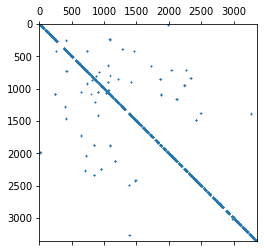

In [57]:
#take submat

print(annotation.iloc[0])
jaccard_connectmat = sparse.COO(jaccard_connectmat)
submat = jaccard_connectmat[annotation.iloc[0].qstart:annotation.iloc[0].qend ,: ]
submat = submat[: , annotation.iloc[0].qstart:annotation.iloc[0].qend  ]


plt.spy(submat.to_scipy_sparse(), markersize =.51)
plt.show()

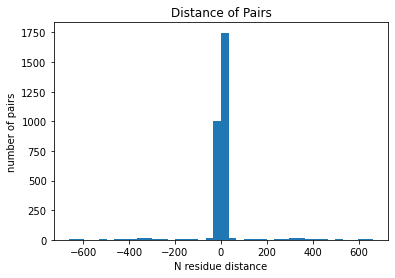

In [58]:
pairs = list(zip(submat.coords[0], submat.coords[1]))

off_diag = [ (p[0]-p[1])/3 for p in pairs ]
plt.hist(off_diag , bins = 40)
plt.title('Distance of Pairs')
plt.xlabel('N residue distance')
plt.ylabel('number of pairs')


plt.show()


In [59]:
pairs = list(zip(submat.coords[0], submat.coords[1]))
pairs = [ (int(p[0]/3), int(p[1]/3)) for p in pairs if np.abs(p[0]-p[1]) > 0]
print(len(pairs))

print(np.array(pairs))

2244
[[   0    1]
 [   1    0]
 [   2    3]
 ...
 [1118 1115]
 [1118 1116]
 [1118 1117]]


In [60]:
subthresh_thresh['7DZW'].keys()

dict_keys(['C', ('A', 'B'), ('A', 'C')])

In [61]:
threshmat = subthresh_thresh['7DZW']['C']+subthresh_thresh['7DZW'][('A', 'C')]+subthresh_thresh['7DZW'][('A', 'B')]
connectmat = subthresh_connected['7DZW']['C'] + subthresh_connected['7DZW'][('A', 'C')] + subthresh_connected['7DZW'][('A', 'B')]


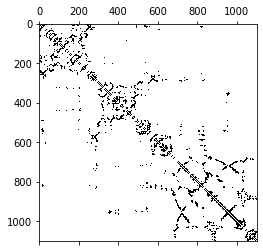

In [62]:
plt.spy(threshmat)
plt.show()

423766
[[   0    1]
 [   0    2]
 [   0    3]
 ...
 [1100 1097]
 [1100 1098]
 [1100 1099]]


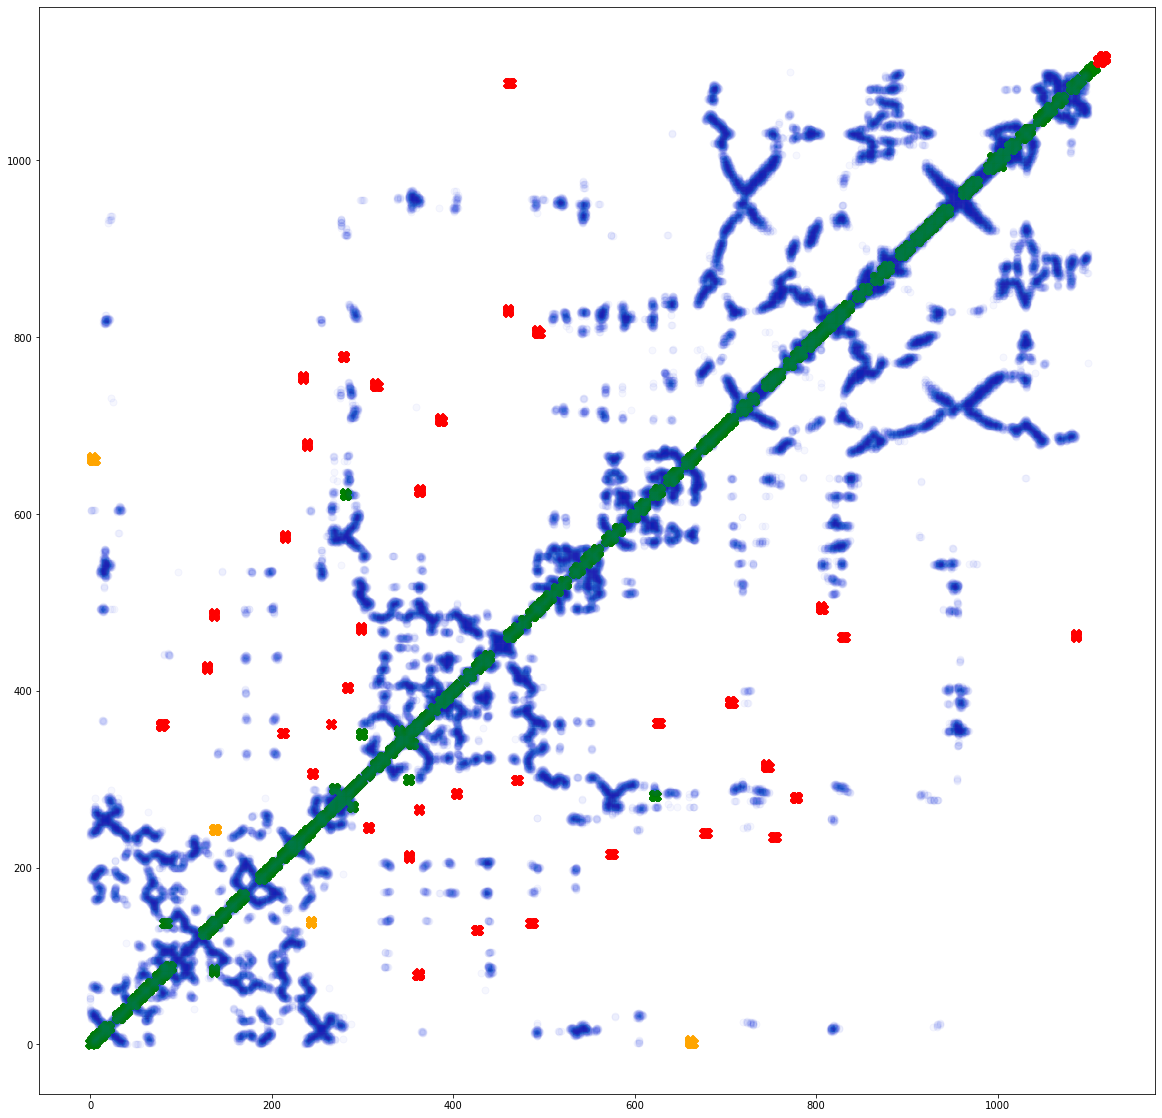

In [63]:
green , orange , red  = struct_hits_filter( pairs , threshmat, connectmat , verbose = False , radius = 10 )

423766
[[   0    1]
 [   0    2]
 [   0    3]
 ...
 [1100 1097]
 [1100 1098]
 [1100 1099]]


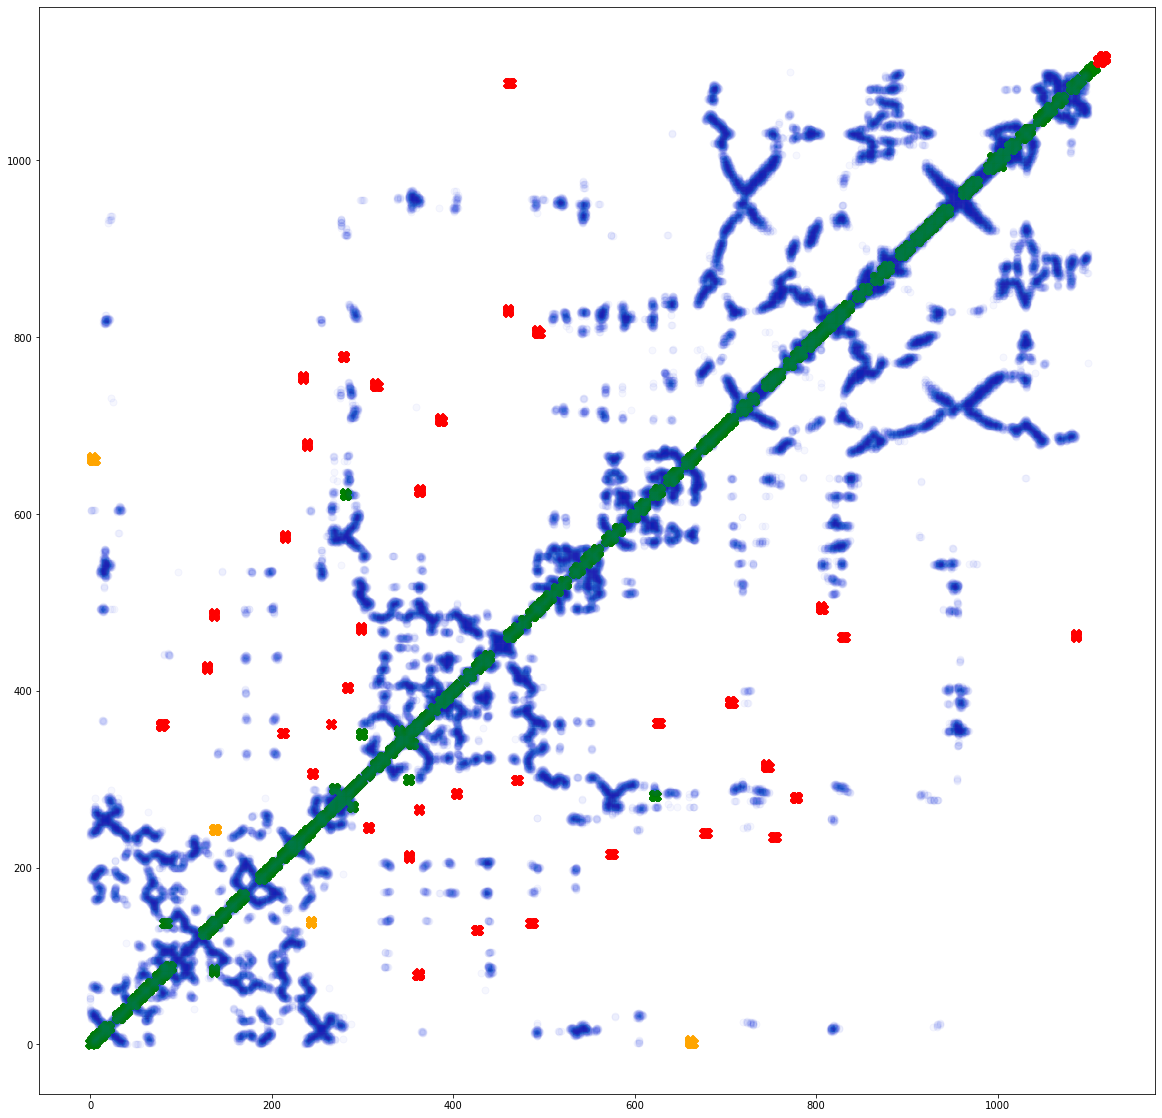

423766
[[   0    1]
 [   0    2]
 [   0    3]
 ...
 [1100 1097]
 [1100 1098]
 [1100 1099]]


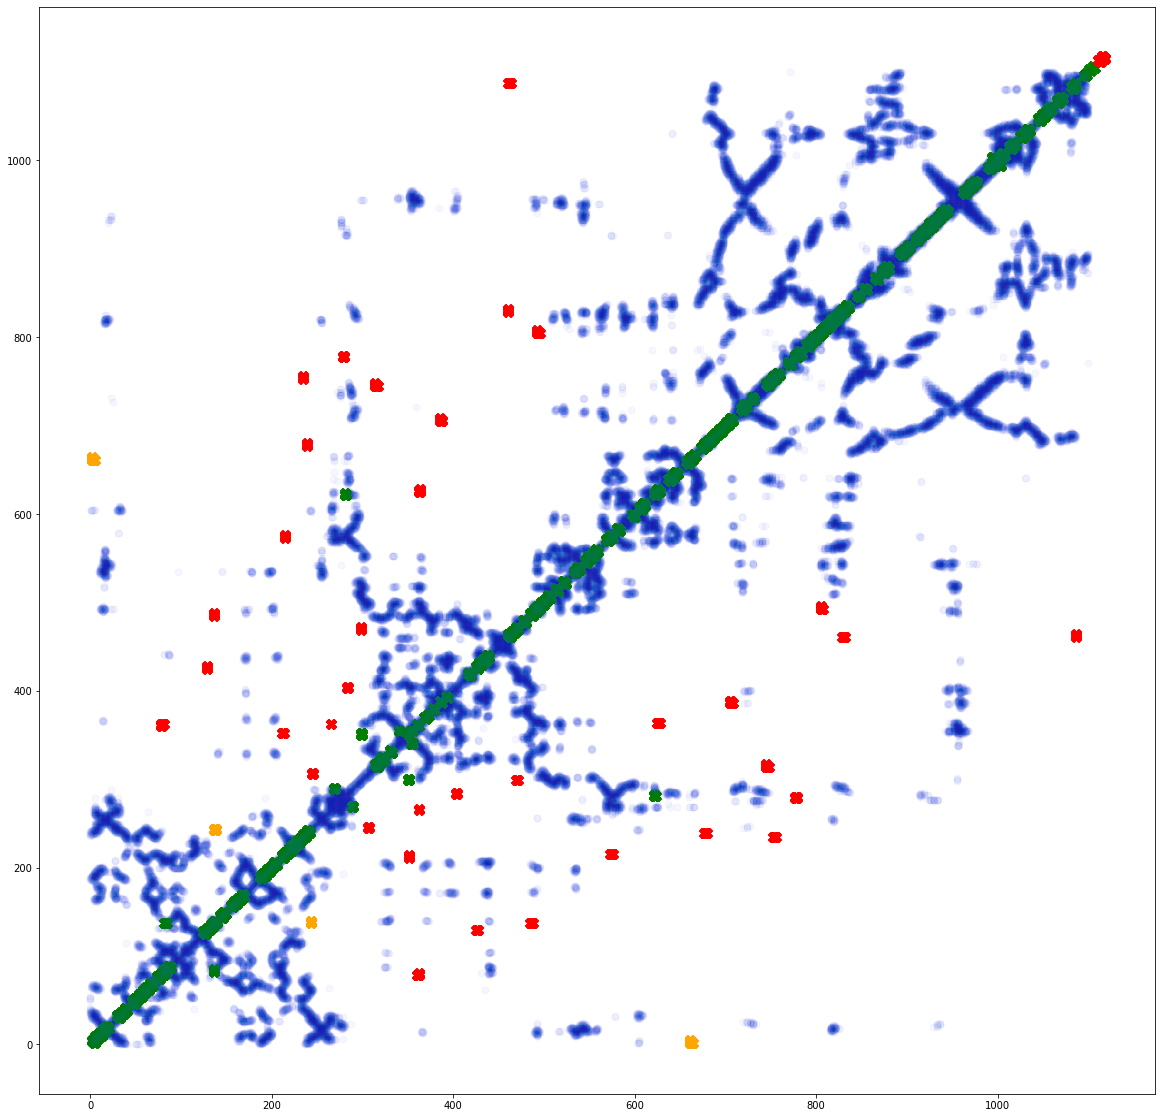

423766
[[   0    1]
 [   0    2]
 [   0    3]
 ...
 [1100 1097]
 [1100 1098]
 [1100 1099]]


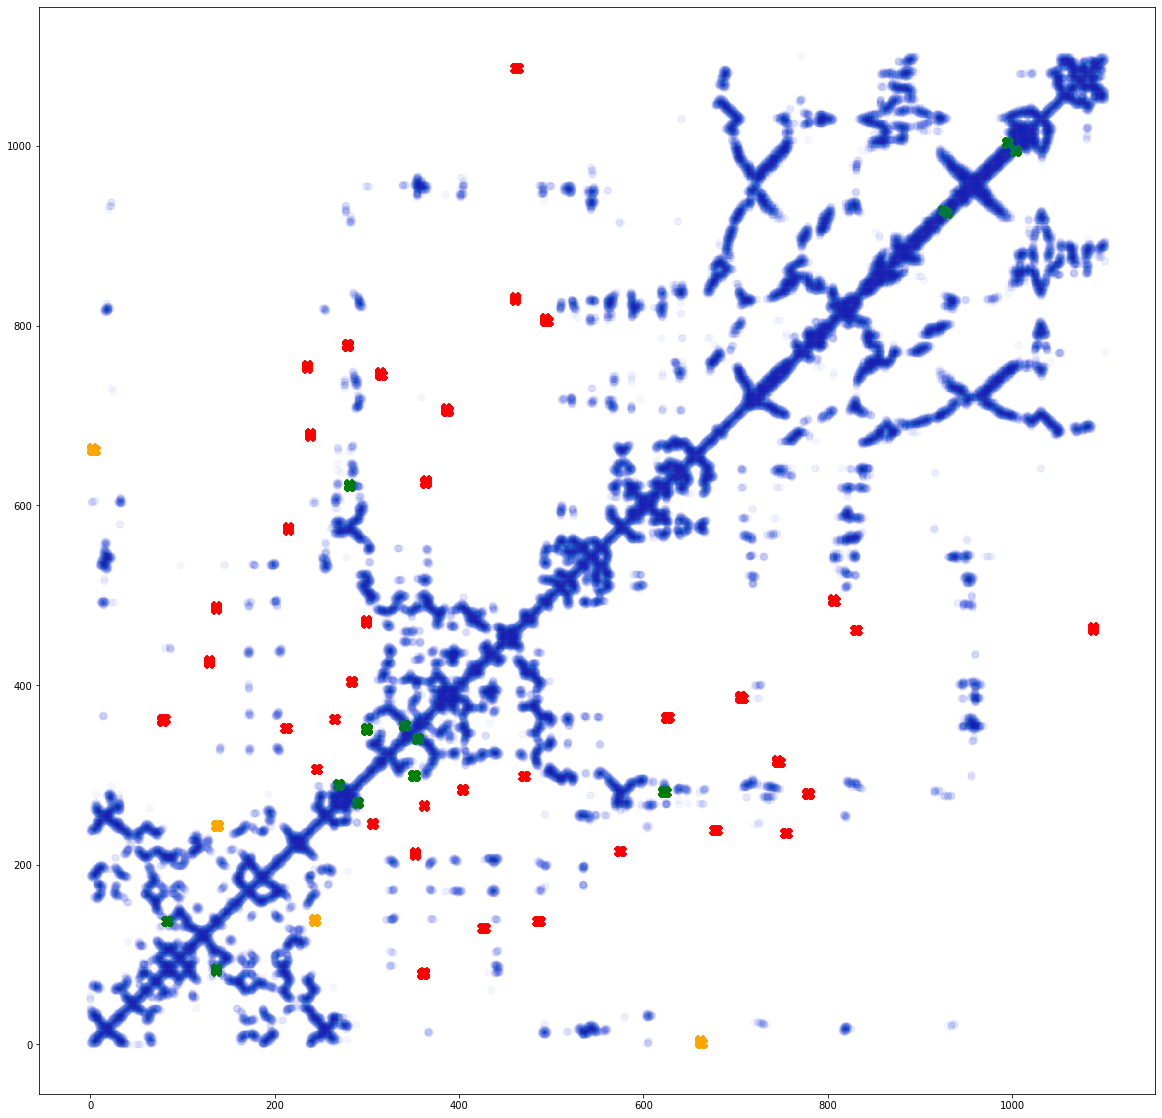

Distance 0
Distance 5
Distance 10


TypeError: can only concatenate list (not "str") to list

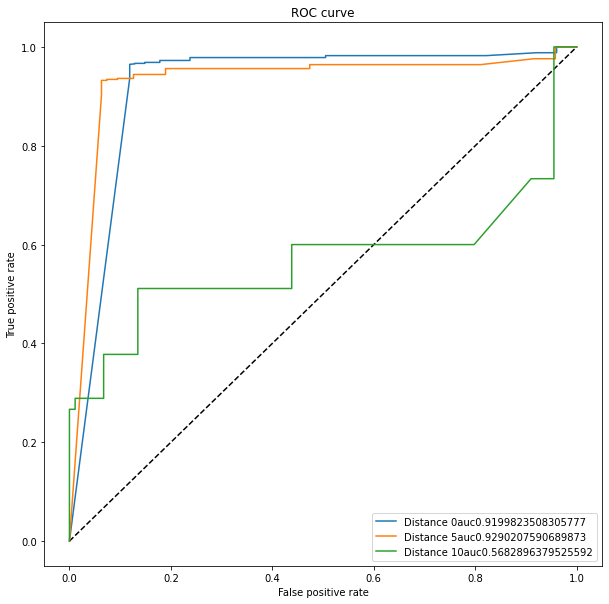

In [64]:


results = {}

threshes = [0,5,10]
for thresh in threshes:
    pairs = list(zip(submat.coords[0], submat.coords[1]))
    pairs = [ (int(p[0]/3), int(p[1]/3)) for p in pairs if np.abs(p[0]-p[1]) > thresh]
    green , orange , red  = struct_hits_filter( pairs , threshmat, connectmat , verbose = False , radius = 10 )
    Trues = list(np.logical_or( green , orange ))
    labels = np.zeros( ( len(Trues) ) ) 
    scores = submat.data
    labels[Trues] = 1
    pairs = list(zip(submat.coords[0], submat.coords[1]))
    data = [ submat.data[i] for i, p in enumerate(pairs) if np.abs(p[0]-p[1]) > thresh]
    
    results['Distance ' + str(thresh)] = {'Ytrue':Trues , 'Ypred':data }
    
    
ROC_curve( results , data)


In [ ]:
model = hk.estimator()
